In [4]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
base_url = "http://agbc-fe.pdn.ac.lk/api/v1/data/?sensor=10008&date="

start_date = pd.to_datetime("2020-10-22")
end_date = pd.to_datetime("2021-03-14")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")

all_data = []

def fetch_data(date):
    date_str = date.strftime("%Y-%m-%d")
    url = base_url + date_str

    try:
        response = requests.get(url)
        data = response.json()
        return data['data']
    except:
        print(f"Error: Could not retrieve data for date {date_str}")
        return []

start_time = time.time()  # Get the current time before starting the execution


# Create a ThreadPoolExecutor with the maximum number of workers
executor = ThreadPoolExecutor(max_workers=None)

# Use tqdm to track the progress
with tqdm(total=len(date_range), desc="Progress", unit="day") as pbar:
    # Submit the fetch_data task to the executor for each date in parallel
    futures = [executor.submit(fetch_data, date) for date in date_range]
    
    # Retrieve the results from the completed futures
    for future in futures:
        all_data.extend(future.result())
        pbar.update(1)
    

end_time = time.time()  # Get the current time after finishing the execution
execution_time = end_time - start_time

print("Execution Time:", execution_time, "seconds")

# Create the DataFrame from the collected data
df = pd.DataFrame(all_data, dtype=str)
df.to_csv('dataws.csv', index=False)


Progress:   0%|          | 0/144 [00:00<?, ?day/s]

Error: Could not retrieve data for date 2020-10-31


Progress: 100%|██████████| 144/144 [01:21<00:00,  1.76day/s]


Execution Time: 81.63674116134644 seconds


In [3]:
# check for missing values
print(df.isnull().sum())

siteId       0
seqNo        0
date         0
time         0
temp1        0
temp2        0
temp3        0
humidity1    0
humidity2    0
humidity3    0
light        0
dtype: int64


In [4]:
# drop rows with missing values
df.dropna(inplace=True)

In [5]:
# Drop duplicate rows
df=df.drop_duplicates(keep='first')

In [6]:
import numpy as np
# Replace '?' with NaN

df.replace(' ?', np.nan, inplace=True)



print(df.tail(10))


       siteId  seqNo         date       time  temp1  temp2  temp3 humidity1  \
340154      0   2869   2021-03-14   23:55:03    NaN   26.1   24.9       NaN   
340155      0   2870   2021-03-14   23:55:31     25   26.2   24.9      79.6   
340156      0   2871   2021-03-14   23:56:01     25   26.1   24.8      79.5   
340157      0   2872   2021-03-14   23:56:31     25   26.1   24.7      79.8   
340158      0   2873   2021-03-14   23:57:01     25   26.1   24.8        80   
340159      0   2874   2021-03-14   23:57:33    NaN   26.2   24.8       NaN   
340160      0   2875   2021-03-14   23:58:03    NaN   26.1   24.8       NaN   
340161      0   2876   2021-03-14   23:58:31   24.9   26.1   24.7      80.3   
340162      0   2877   2021-03-14   23:59:01   24.9   26.1   24.8      80.4   
340163      0   2878   2021-03-14   23:59:31   24.9   26.1   24.8      80.5   

       humidity2 humidity3   light  
340154        80        40   1.042  
340155        80        40   1.042  
340156        80   

<h2>Create a new DataFrame with Average Temperature and Average Humidity Values </h2>

In [7]:
# Convert temperature columns to numeric
df['temp1'] = pd.to_numeric(df['temp1'], errors='coerce')
df['temp2'] = pd.to_numeric(df['temp2'], errors='coerce')
df['temp3'] = pd.to_numeric(df['temp3'], errors='coerce')

# Convert temperature columns to numeric
df['humidity1'] = pd.to_numeric(df['humidity1'], errors='coerce')
df['humidity2'] = pd.to_numeric(df['humidity2'], errors='coerce')
df['humidity3'] = pd.to_numeric(df['humidity3'], errors='coerce')

df['seqNo'] = pd.to_numeric(df['seqNo'], errors='coerce')

# Calculate the average temperature
df['average_internal_temp'] = df[['temp1', 'temp2', 'temp3']].mean(axis=1,skipna=True)

# Calculate the average humidity
df['average_internal_humidity'] = df[['humidity1', 'humidity2', 'humidity3']].mean(axis=1,skipna=True)

# Create a new DataFrame with only the desired columns
new_df = df[['seqNo','date','time','average_internal_temp', 'average_internal_humidity', 'light']]


print(new_df.head())



   seqNo         date       time  average_internal_temp  \
0      1   2020-10-22   00:00:01              23.433333   
1      2   2020-10-22   00:00:18              23.550000   
2      3   2020-10-22   00:00:31              23.433333   
3      4   2020-10-22   00:00:46              23.466667   
4      5   2020-10-22   00:01:01              23.400000   

   average_internal_humidity   light  
0                  96.300000   1.042  
1                  95.000000   1.042  
2                  96.266667   1.042  
3                  96.200000   1.042  
4                  96.166667   1.042  


<h2> Create a Data frame for Internal Sensor 10008 data </h2>

In [8]:
# Combine the 'date' and 'time' columns into a single datetime column
new_df['datetime'] = pd.to_datetime(new_df['date'] + ' ' + new_df['time'])
# Set the 'time' column as the DataFrame index
new_df.set_index('datetime', inplace=True)
new_df.drop(['date', 'time','seqNo'], axis=1, inplace=True)
# Resample the DataFrame using 'H' offset alias and select the first entry from each hour
new_df_hourly = new_df.resample('H').first()

# new_df_hourly.reset_index(inplace=True)
# Print the resulting DataFrame

new_df_hourly.to_csv('sensor10008.csv', index=False)

/var/folders/jc/5dgg62dn62g30jn00c_29n180000gn/T/ipykernel_90061/77695520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['datetime'] = pd.to_datetime(new_df['date'] + ' ' + new_df['time'])
/var/folders/jc/5dgg62dn62g30jn00c_29n180000gn/T/ipykernel_90061/77695520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<h2> Create a Data frame for External Environmental data </h2>

In [9]:
# Load the CSV file into a DataFrame
external_weather = pd.read_csv('weather_data.csv')

# Combine the 'Date' and 'Time' columns into a single datetime column
external_weather['datetime'] = pd.to_datetime(external_weather['date'] + ' ' + external_weather['time'])

external_weather.drop(["time","date"],axis=1,inplace=True)

external_weather.set_index('datetime', inplace=True)

merged_df = pd.merge(external_weather, new_df_hourly, on='datetime')

# Drop rows with any null values
merged_df.dropna(inplace=True)

merged_df.to_csv('data_set.csv')






In [12]:
# from pandas_profiling import ProfileReport

# # Create a profile report for your DataFrame
# profile = ProfileReport(merged_df)

# # Generate the report and save it as an HTML file
# profile.to_file('profile_report.html')

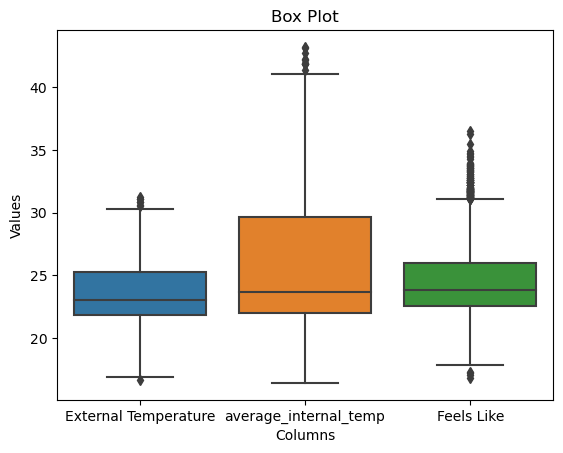

In [11]:
# Specify the columns for the box plot
columns_to_plot = ['External Temperature', 'average_internal_temp','Feels Like']

# Create the box plot using seaborn
sns.boxplot(data=merged_df[columns_to_plot])

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot')

# Show the plot
plt.show()

<h2> Extracting features and target variable </h2>

In [12]:

from sklearn.model_selection import train_test_split


y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]



<h2> Model Trained By  LinearRegression</h2>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = model.score(X_train, y_train)

# Calculate test accuracy
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:",test_accuracy)

print(type(X_test))


Training Accuracy: 0.22630530781151162
Test Accuracy: 0.2522579488510137
<class 'pandas.core.frame.DataFrame'>


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RandomForestRegressor


# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Training the linear regression model
model =RandomForestRegressor()
model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = model.score(X_train, y_train)

# Calculate test accuracy
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:",test_accuracy)

print(type(X_test))


NameError: name 'RandomForestRegressor' is not defined

<h2> Model Trained By  DecisionTree Regressor</h2>

In [55]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import optuna
# Assuming you have your input features in X and output features in y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    
    # Create the decision tree regressor object with the suggested parameters
    clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    # Fit the model to the training data
    clf.fit(X_train, y_train)
    
    # Calculate the test accuracy
    test_accuracy = clf.score(X_test, y_test)
    
    return test_accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters from the study
best_params = study.best_params


clf = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])
clf.fit(X_train, y_train)


print("Best Max Depth is : ",best_params['max_depth'])

print("Best Min Samples Leaf is : ",best_params['min_samples_leaf'])
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



[I 2023-06-07 21:19:49,105] A new study created in memory with name: no-name-1fc0ea65-2661-46c1-ac4f-c643188405eb
[I 2023-06-07 21:19:49,126] Trial 0 finished with value: 0.2355344738305678 and parameters: {'max_depth': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.2355344738305678.
[I 2023-06-07 21:19:49,138] Trial 1 finished with value: 0.16897677675994752 and parameters: {'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.2355344738305678.
[I 2023-06-07 21:19:49,155] Trial 2 finished with value: 0.197824114958684 and parameters: {'max_depth': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.2355344738305678.
[I 2023-06-07 21:19:49,169] Trial 3 finished with value: 0.22885115631455066 and parameters: {'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2355344738305678.
[I 2023-06-07 21:19:49,180] Trial 4 finished with value: 0.21541983546013163 and parameters: {'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value

Best Max Depth is :  4
Best Min Samples Leaf is :  7
Training Accuracy: 0.365247381232352
Test Accuracy: 0.23553447383056728


<h2> Model Trained By Lasso</h2>

In [57]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have a pandas DataFrame 'data' containing your feature columns (X) and target column (y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create the Lasso regression model
lasso = Lasso(alpha=0.001)  # Adjust the alpha parameter to control the degree of regularization

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Get the score (coefficient of determination) on the testing data
score = lasso.score(X_test, y_test)
print("Score:", score)

Mean Squared Error: 9205226.375951892
Score: 0.21910478812166045


<h2>Model Trained By Ridge regression </h2>

In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming you have your feature matrix X and target variable y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended for regularization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Ridge regression model
ridge = Ridge(alpha=1.0)  # You can adjust the regularization strength by changing the alpha parameter

# Train the model
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 9199522.69808088
R2 Score: 0.21962995795551687


<h1>MLPRegressor</h1>

In [59]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [60]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import accuracy_score

# Assuming you have your feature matrix X and target variable y
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
# Create the model
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict the target values for the testing set
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)
print('Score:', score)

Score: -0.0011481089061574634


<h1>RANDOM FOREST REGRESSOR</h1> 39% accuracy

In [61]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import accuracy_score

# Assuming you have your feature matrix X and target variable y
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
# Create the model
model =RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the target values for the testing set
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)
print('Score:', score)


train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Score: 0.4105804367043759
Training Accuracy: 0.7917583974727208
Test Accuracy: 0.4105804367043759


In [63]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


     -------------------------------------- 266.3/266.3 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 3.9 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 126.5/126.5 kB ? eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 896.6/896.6 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 93.9/93.9

In [ ]:
# **Simple neural network**

import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Convert the X_train and y_train variables to type float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_train= tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train= tf.convert_to_tensor(y_train, dtype=tf.float32)

# Train the model
model.fit(X_train, y_train, epochs=100)

# Evaluate the model
model.evaluate(X_test, y_test)

# **Deep neural network**

import tensorflow as tf

# Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Convert the X_train and y_train variables to type float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Train the model
model.fit(X_train, y_train, epochs=100)

# Evaluate the model
model.evaluate(X_test, y_test)


ModuleNotFoundError: No module named 'tensorflow'

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2970 sha256=7b142af98f9f9fa06f67c4ea6a8f3a720e69f40256ec2216bc0d5c3d1d7dfec0
  Stored in directory: c:\users\vilak\appdata\local\pip\cache\wheels\b2\af\1b\ac28f3fb36a8428e3089acdd913e9ee1808e781e3ff6ce2929
Successfully built sklearn
  Using cached sklearn-0.0.post5-py3-none-any.whl


Note: you may need to restart the kernel to use updated packages.


<h1>CNN</h1>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

# Define the model architecture
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(6,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))  # Output layer with 3 units for the 3 output columns

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass and compute the loss
    history = model.fit(train_X, train_y, batch_size=32, epochs=1, verbose=0)

    # Compute training and testing accuracy
    train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)

    # Print the loss and accuracy after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {history.history['loss'][0]}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# Evaluation
predictions = model.predict(test_X)
# Perform further evaluation or analysis on the predictions


Epoch 1/10, Loss: 12632283.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 2/10, Loss: 11679390.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 3/10, Loss: 11610776.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 4/10, Loss: 11662118.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 5/10, Loss: 11680528.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 6/10, Loss: 11602964.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 7/10, Loss: 11607462.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 8/10, Loss: 11577952.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 9/10, Loss: 11553023.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 10/10, Loss: 11655988.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.490333

<h1>Architecture similar to VGG net</h1>


In [35]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

# Reshape the input data to match the VGG16 input shape
X = X.reshape(-1, 4, 1, 1)

# Define the VGG-like model architecture
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(4, 1, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3))  # Output layer with 3 units for the 3 output columns

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# # Training loop
# num_epochs = 300

# for epoch in range(num_epochs):
#     # Forward pass and compute the loss
#     history = model.fit(train_X, train_y, batch_size=32, epochs=1, verbose=0)

#     # Compute training and testing accuracy
#     train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
#     test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)

#     # Print the loss and accuracy after each epoch
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {history.history['loss'][0]}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# # Evaluation
# predictions = model.predict(test_X)
# Perform further evaluation or analysis on the predictions


# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=300, mode='max')
checkpoint_callback = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Training loop
num_epochs = 300

history = model.fit(train_X, train_y, batch_size=32, epochs=num_epochs, validation_data=(test_X, test_y),
                    callbacks=[early_stopping_callback, checkpoint_callback])

# Load the best model saved during training
model = models.load_model('model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy}")

import matplotlib.pyplot as plt

# num_epochs = 400

# history = model.fit(train_X, train_y, batch_size=32, epochs=num_epochs, validation_data=(test_X, test_y), verbose=1)

# Retrieve accuracy values from history
train_accuracy = history.history['accuracy'] 
test_accuracy = history.history['val_accuracy']

# Plot accuracy
# plt.plot(range(1, num_epochs + 1), train_accuracy, label='Train Accuracy')
# plt.plot(range(1, num_epochs + 1), test_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Epoch 1/300
72/72 [==============================] - 3s 36ms/step - loss: 12229990.0000 - accuracy: 0.4490 - val_loss: 28755816.0000 - val_accuracy: 0.4903
Epoch 2/300
72/72 [==============================] - 1s 19ms/step - loss: 12030541.0000 - accuracy: 0.4490 - val_loss: 28832136.0000 - val_accuracy: 0.4903
Epoch 3/300
72/72 [==============================] - 1s 18ms/step - loss: 11857734.0000 - accuracy: 0.4490 - val_loss: 30121014.0000 - val_accuracy: 0.4903
Epoch 4/300
72/72 [==============================] - 1s 18ms/step - loss: 11878405.0000 - accuracy: 0.4490 - val_loss: 28495934.0000 - val_accuracy: 0.4903
Epoch 5/300
72/72 [==============================] - 1s 20ms/step - loss: 12350944.0000 - accuracy: 0.4490 - val_loss: 26954842.0000 - val_accuracy: 0.4903
Epoch 6/300
72/72 [==============================] - 1s 18ms/step - loss: 11579131.0000 - accuracy: 0.4490 - val_loss: 27955748.0000 - val_accuracy: 0.4903
Epoch 7/300
72/72 [==============================] - 1s 20ms/ste

In [29]:
import numpy as np

# Prepare new input data (example)
new_input = np.array([[25.0, 1013.0, 60.0, 15.0, 40.0, 10.0]], dtype='float32')
new_input = new_input.reshape(-1, 6, 1, 1)

# Load the trained model
model = models.load_model('model.h5')

# Make predictions
predictions = model.predict(new_input)

# Print the predictions
print(f"Predicted values: {predictions}")

1/1 [==============================] - 0s 484ms/step
Predicted values: [[  24.416098   98.31037  3925.4536  ]]


<h1>LSTM</h1>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

# Define the model architecture
model = models.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(None, 6)))
model.add(layers.LSTM(128))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))  # Output layer with 3 units for the 3 output columns

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Reshape the input data for the RNN
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass and compute the loss
    history = model.fit(train_X, train_y, batch_size=32, epochs=1, verbose=0)

    # Compute training and testing accuracy
    train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)

    # Print the loss and accuracy after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {history.history['loss'][0]}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# Evaluation
predictions = model.predict(test_X)
# Perform further evaluation or analysis on the predictions


Epoch 1/100, Loss: 15612470.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 2/100, Loss: 14598738.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 3/100, Loss: 12457932.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 4/100, Loss: 11612101.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 5/100, Loss: 11579144.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 6/100, Loss: 11580081.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 7/100, Loss: 11579932.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 8/100, Loss: 11586812.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 9/100, Loss: 11577862.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 10/100, Loss: 11584354.0, Train Accuracy: 0.44898855686187744, Test Accuracy

<h1>RESNET</h1>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

# Preprocess the input data (optional, depending on your specific use case)
# ...

# Modify the ResNet architecture for regression
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom regression layers on top of the base model
model = models.Sequential()
model.add(layers.Input(shape=(6,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Reshape((4, 4, 128)))
# model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(3))  # Output layer with 3 units for the 3 output columns

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass and compute the loss
    history = model.fit(train_X, train_y, batch_size=32, epochs=1, verbose=0)

    # Compute training and testing accuracy
    train_loss, train_accuracy = model.evaluate(train_X, train_y, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)

    # Print the loss and accuracy after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {history.history['loss'][0]}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# Evaluation
predictions = model.predict(test_X)
# Perform further evaluation or analysis on the predictions


Epoch 1/100, Loss: 12964691.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 2/100, Loss: 11614191.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 3/100, Loss: 11596519.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 4/100, Loss: 11618454.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 5/100, Loss: 11592729.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 6/100, Loss: 11594659.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 7/100, Loss: 11594632.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 8/100, Loss: 11562349.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 9/100, Loss: 11606548.0, Train Accuracy: 0.44898855686187744, Test Accuracy: 0.4903339147567749
Epoch 10/100, Loss: 11599482.0, Train Accuracy: 0.44898855686187744, Test Accuracy

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

def dense_block(x, blocks, growth_rate):
    for _ in range(blocks):
        y = layers.BatchNormalization()(x)
        y = layers.Activation('relu')(y)
        y = layers.Dense(4 * growth_rate)(y)
        y = layers.BatchNormalization()(y)
        y = layers.Activation('relu')(y)
        y = layers.Dense(growth_rate)(y)
        x = layers.Concatenate()([x, y])
    return x

def transition_block(x, reduction):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(int(tf.keras.backend.int_shape(x)[-1] * reduction))(x)
    return x

def build_regression_model(input_shape, blocks_per_layer, growth_rate, reduction, output_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Dense(64)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    for blocks in blocks_per_layer:
        x = dense_block(x, blocks, growth_rate)
        x = transition_block(x, reduction)
    
    # x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(output_shape, activation='linear')(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

# Create an instance of the regression model
input_shape = (6,)
blocks_per_layer = [6, 12, 24, 16]
growth_rate = 32
reduction = 0.5
output_shape = 3

regression_model = build_regression_model(input_shape, blocks_per_layer, growth_rate, reduction, output_shape)
# Compile the regression model
regression_model.compile(optimizer='adam', loss='mean_squared_error',metrics='accuracy')

# Train the regression model
history=regression_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the regression model on the training set
train_loss = regression_model.evaluate(X_train, y_train)

# Evaluate the regression model on the testing set
test_loss = regression_model.evaluate(X_test, y_test)

# Print the training and testing accuracy
train_accuracy = 1 - train_loss
test_accuracy = 1 - test_loss

print("Training Accuracy: {:.2%}".format(train_accuracy))
print("Testing Accuracy: {:.2%}".format(test_accuracy))


Epoch 1/10
17/72 [======>.......................] - ETA: 8:10 - loss: 19098368.0000 - accuracy: 0.4320

KeyboardInterrupt: 

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the input and output data from the pandas DataFrame
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']]

# Convert the pandas DataFrame to numpy arrays with float32 data type
X = X.astype('float32').to_numpy()
y = y.astype('float32').to_numpy()

def dense_block(x, blocks, growth_rate):
    for _ in range(blocks):
        y = layers.BatchNormalization()(x)
        y = layers.Activation('relu')(y)
        y = layers.Dense(4 * growth_rate)(y)
        y = layers.BatchNormalization()(y)
        y = layers.Activation('relu')(y)
        y = layers.Dense(growth_rate)(y)
        x = layers.Concatenate()([x, y])
    return x

def transition_block(x, reduction):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(int(tf.keras.backend.int_shape(x)[-1] * reduction))(x)
    return x

def build_regression_model(input_shape, blocks_per_layer, growth_rate, reduction, output_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Reshape((input_shape[0], 1))(inputs)  # Reshape the input to add a channel dimension
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    for blocks in blocks_per_layer:
        x = dense_block(x, blocks, growth_rate)
        x = transition_block(x, reduction)
    
    # x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(output_shape, activation='linear')(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

# Create an instance of the regression model
input_shape = (6,)
blocks_per_layer = [6, 12, 24, 16]
growth_rate = 32
reduction = 0.5
output_shape = 3

regression_model = build_regression_model(input_shape, blocks_per_layer, growth_rate, reduction, output_shape)
# Compile the regression model
regression_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the regression model
regression_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Evaluate the regression model on the training set
train_loss = regression_model.evaluateX_train, y_train)

# Evaluate the regression model on the testing set
test_loss = regression_model.evaluate(X_test, y_test)

# Print the training and testing accuracy
train_accuracy = 1 - train_loss
test_accuracy = 1 - test_loss

print("Training Accuracy: {:.2%}".format(train_accuracy))
print("Testing Accuracy: {:.2%}".format(test_accuracy))


Clustering

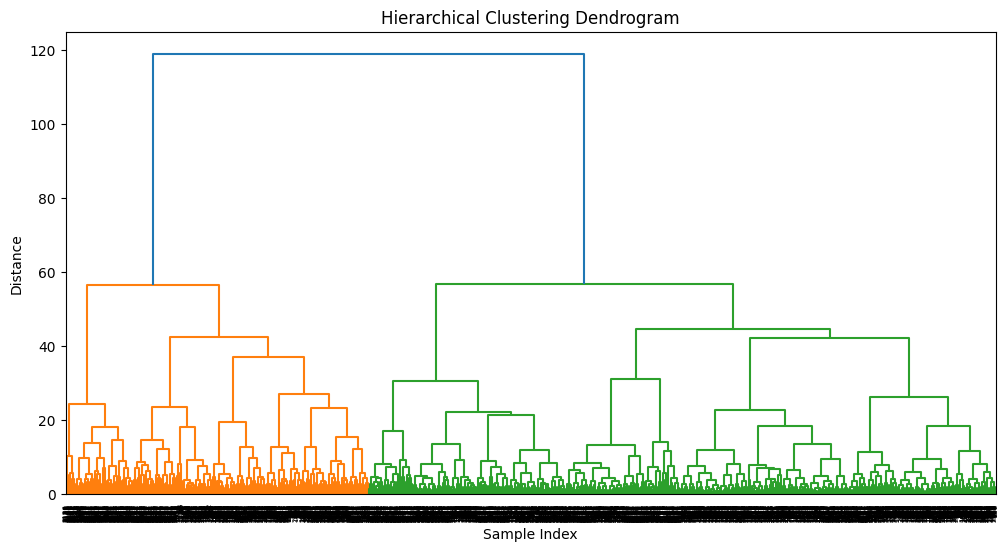

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('weather_data.csv')

# Select the columns for clustering
columns_for_clustering = ['External Temperature', 'Feels Like', 'Pressure', 'External Humidity', 'Dew Point', 'Clouds', 'Wind Speed']
data = df[columns_for_clustering]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate the linkage matrix
linkage_matrix = linkage(scaled_data, method='ward')  # You can choose a different method if needed

# Plot the dendrogram to visualize the clusters
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, p=30, truncate_mode='level')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


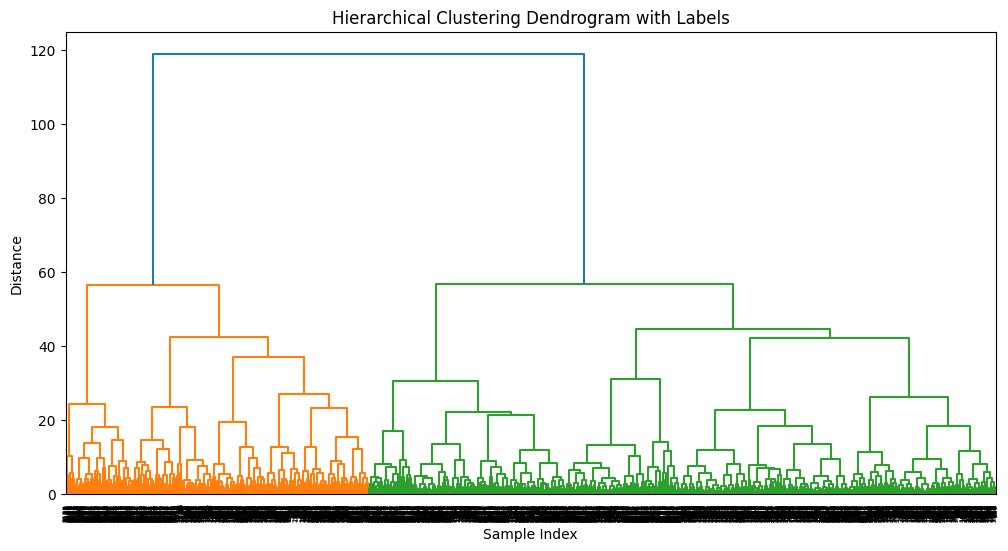

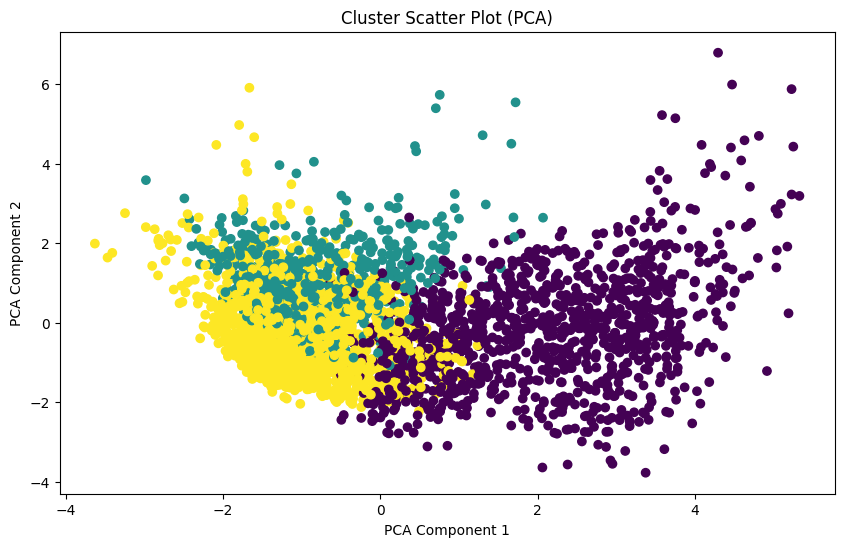

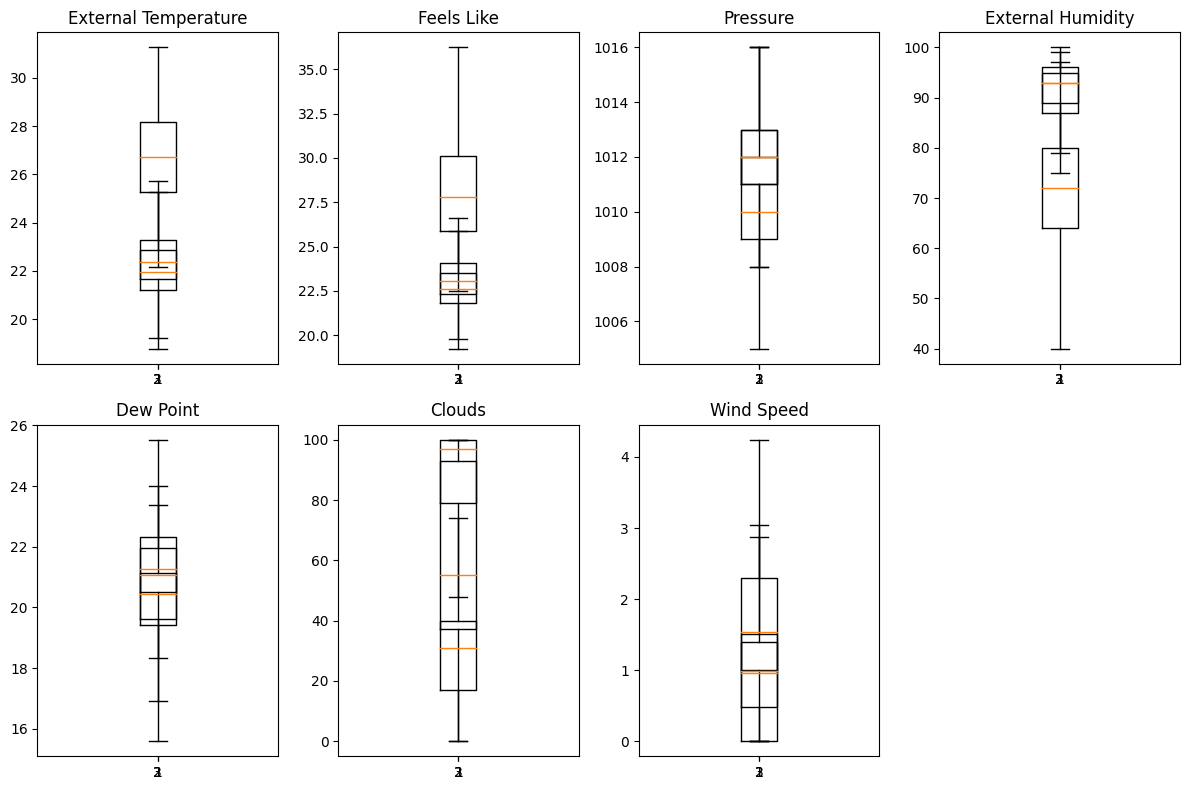

In [13]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster

# Determine the number of clusters based on dendrogram
num_clusters = 3  # Adjust this based on your analysis of the dendrogram
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
df['Cluster'] = cluster_labels

# Plot the dendrogram with labels
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, p=30, truncate_mode='level', labels=df.index)
plt.title('Hierarchical Clustering Dendrogram with Labels')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Add cluster labels to the DataFrame
df['Cluster'] = cluster_labels  # Use the cluster labels obtained earlier

# Plot a scatter plot with cluster colors
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Cluster Scatter Plot (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Create subplots for each feature
plt.figure(figsize=(12, 8))
for i, feature in enumerate(columns_for_clustering):
    plt.subplot(2, 4, i+1)
    for cluster in range(1, num_clusters+1):
        plt.boxplot(df[df['Cluster'] == cluster][feature], labels=[cluster], showfliers=False)
    plt.title(feature)
plt.tight_layout()
plt.show()

